###**infant_hfb_ml**

This notebook address three goals, each linked to a primary result in Holubecki et al., 2025:  
1. **Analyze high-frequency broadband activity (HFB: 70-150 Hz) using Python with MNE**, reproducing results reported from analysis using MATLAB with FieldTrip. Successfully converted FieldTrip preprocessing pipeline to MNE, ensuring identical parameter matching (multitaper method, frequency bands, and normalization).
2. **Classify wake vs. sleep states using all available HFB data from a single channel.** Using logistic regression with 70/30 train/test split across all subjects, Fz HFB (located over the anterior fontanelle with minimal skull attenuation) successfully discriminated states (ROC-AUC = 0.78). By contrast, P3 HFB (over relatively thick skull) showed chance-level performance (ROC-AUC = 0.5), as expected given equivalent mean HFB values between states. Within-subject standardization with subject-based splitting improved Fz performance (ROC-AUC = 0.895), demonstrating that wake/sleep HFB differences follow consistent within-subject patterns despite between-subject variability in absolute power levels. The full sample includes data (20+ samples per state) from 17 subjects with Fz and 14 subjects with P3.
3. **Classify wake vs. sleep states using limited training data (5 samples per condition from 10 subjects).** Using 10-fold cross-validation with random splits, Fz HFB maintained moderate discrimination ability with limited data, while P3 performed below chance level, consistent with the ground truth that no signal exists in P3. Within-subject standardization with leave-one-subject-out cross-validation enabled cross-subject generalization, improving Fz performance. However, P3 showed unexpected above-chance performance, likely reflecting overfitting to noise with limited data. This demonstrates that brief data collection sessions from a modest sample can support wake/sleep classification within subjects using Fz HFB, but not cross-subject generalization.

Copyright (c) 2025  
EL Johnson, PhD

###Import modules:

In [1]:
import gdown
import zipfile
import matplotlib.pyplot as plt

!pip install mne  # for custom modules

# custom modules
from hfb_utils import load_eeg_files, compute_hfb, create_hfb_df
from ml_utils import classify_wake_sleep, compare_classifiers, \
  classify_wake_sleep_standardized, classify_kfold, classify_loocv_standardized

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 97.6 MB/s eta 0:00:00


###Download data from Google Drive:

In [2]:
# download
fid = '1DX7D6iWITATB8Tn5oLuez4rJj3obWhOA'
url = f'https://drive.google.com/uc?id={fid}'
gdown.download(url, 'All_Data_clean_z.zip', quiet = False)

# unzip
with zipfile.ZipFile('All_Data_clean_z.zip', 'r') as zip_ref:
  zip_ref.extractall()

Downloading...
From (original): https://drive.google.com/uc?id=1DX7D6iWITATB8Tn5oLuez4rJj3obWhOA
From (redirected): https://drive.google.com/uc?id=1DX7D6iWITATB8Tn5oLuez4rJj3obWhOA&confirm=t&uuid=2001f67f-1a9a-49af-a274-651dd5b65e2a
To: /content/All_Data_clean_z.zip
100%|██████████| 1.60G/1.60G [00:22<00:00, 70.1MB/s]


### Load the data

Each MATLAB input file contains two data structures per subject (`awake_eeg` and `sleep_eeg`), which are the output of FieldTrip's `ft_preprocessing`. Each structure contains the following variables of interest:
- `label` = channel names
- `time` = time vectors for each trial (sec)
- `trial` = EEG data (channels x timepoints per epoch)
- `fsample` = sampling rate (Hz)

The `load_eeg_files()` function converts these FieldTrip structures directly into MNE `Epochs` objects. Each output is a dictionary containing two MNE `Epochs` objects per subject (e.g., `Subj1_awake` and `Subj1_sleep`), preserving all channel info, trial data, and sampling parameters from the original MATLAB structures.

In [3]:
all_data = load_eeg_files()

Found 18 files

Loading Subj19...
Loading Subj14...
Loading Subj20...
Loading Subj18...
Loading Subj2...
Loading Subj8...
Loading Subj7...
Loading Subj10...
Loading Subj6...
Loading Subj13...
Loading Subj15...
Loading Subj11...
Loading Subj17...
Loading Subj5...
Loading Subj22...
Loading Subj1...
Loading Subj12...
Loading Subj16...


In [4]:
all_data['Subj1_awake']  # take a look

<EpochsArray | 120 events (all good), 0 – 4.999 s (baseline off), ~54.9 MiB, data loaded,
 '1': 120>

### Goal 1: Reproduce MATLAB-FieldTrip HFB analysis using Python-MNE

**Conversion process**: The FieldTrip analysis computed PSD using the multitaper method (`ft_freqanalysis` with `method` = 'mtmfft', `taper` = 'dpss'). The equivalent MNE function is `mne.time_frequency.psd_array_multitaper`. The challenge was matching FieldTrip's exact frequency bins and parameters to ensure identical results.  

**Key parameter matching**:
- **Frequency range**: FieldTrip used `cfg.foi` = 75:10:145 (8 specific frequencies). MNE computes all frequencies in the range, requiring selection of the closest bins to match FieldTrip's exact frequencies.
- **Spectral smoothing**: FieldTrip's `cfg.tapsmofrq` = 10/2 specifies half-bandwidth (+/-5 Hz smoothing). This maps to MNE's `bandwidth` = 10 parameter.
- **Normalization**: Both FieldTrip's `output` = 'pow' and MNE's `normalization` = 'full' return PSD in units of power/Hz.
- **Frequency normalization**: Following the FieldTrip pipeline, PSD values were multiplied by their corresponding frequencies, then averaged across frequency bands.  

**Verification**: Comparing mean HFB power values from both pipelines confirmed success:
- Fz: awake mean = 0.0152, sleep mean = 0.0064 (awake > sleep, as expected)
- P3: awake mean = 0.0236, sleep mean = 0.0238 (awake essentially = sleep, as expected)

In [5]:
all_hfb = compute_hfb(all_data)

Processing Subj10...
Processing Subj13...
Processing Subj20...
Processing Subj22...
Processing Subj12...
Processing Subj2...
Processing Subj11...
Processing Subj15...
Processing Subj6...
Processing Subj8...
Processing Subj7...
Processing Subj18...
Processing Subj17...
Processing Subj1...
Processing Subj5...
Processing Subj14...
Processing Subj19...
Processing Subj16...


In [6]:
all_hfb['Subj1'].keys()  # take a look

dict_keys(['awake_power', 'sleep_power', 'ch_awake', 'ch_sleep', 'ch_indices_awake', 'ch_indices_sleep', 'all_channels', 'mean_freq', 'freqs'])

###Select data for ML analysis:  

Each model uses data from a single channel:
- Fz, located over the anterior fontanelle. Hierarchical modeling revealed the greatest HFB wake > sleep difference in Fz. ML models with Fz HFB data as the feature should classify wake vs. sleep states.
- P3, located over relatively thick skull. Hierarchical modeling indicated a non-significant HFB wake-sleep difference in P3. ML models with P3 HFB data as the feature should not classify wake vs. sleep states.  

In [7]:
df = create_hfb_df(all_hfb)

print(f'Created df with {len(df)} total epochs:')
print(f'  Awake: {(df.condition == "awake").sum()}')
print(f'  Sleep: {(df.condition == "sleep").sum()}')
print(f'  Fz total: {df.fz_hfb.notna().sum()}')
print(f'  P3 total: {df.p3_hfb.notna().sum()}')

Created df with 3321 total epochs:
  Awake: 1197
  Sleep: 2124
  Fz total: 3213
  P3 total: 2589


Summarize Fz and P3 data to confirm:

fz_hfb:
  Awake mean: 0.0152, SD: 0.0148
  Sleep mean: 0.0064, SD: 0.0069
p3_hfb:
  Awake mean: 0.0236, SD: 0.0234
  Sleep mean: 0.0238, SD: 0.0289


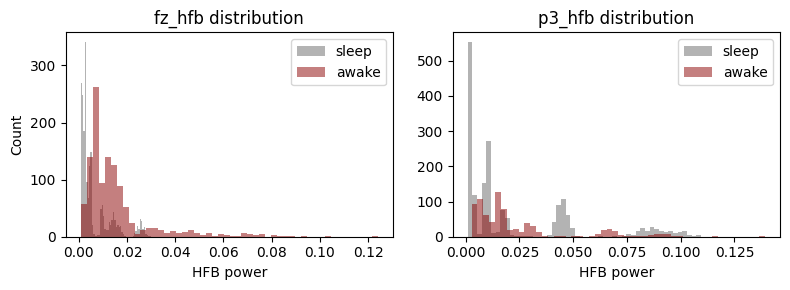

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (8, 3))

for idx, channel in enumerate(['fz_hfb', 'p3_hfb']):
  df_clean = df[df[channel].notna()].copy()

  awake_vals = df_clean[df_clean.condition == 'awake'][channel]
  sleep_vals = df_clean[df_clean.condition == 'sleep'][channel]

  ax[idx].hist(sleep_vals, bins = 50, alpha = 0.5, label = 'sleep', color = 'dimgray')
  ax[idx].hist(awake_vals, bins = 50, alpha = 0.5, label = 'awake', color = 'darkred')
  ax[idx].set_xlabel('HFB power')
  ax[idx].set_title(f'{channel} distribution')
  ax[idx].legend()

  ax[0].set_ylabel('Count')

  print(f'{channel}:')
  print(f'  Awake mean: {awake_vals.mean():.4f}, SD: {awake_vals.std():.4f}')
  print(f'  Sleep mean: {sleep_vals.mean():.4f}, SD: {sleep_vals.std():.4f}')

plt.tight_layout()
plt.show()

### Goal 2.1: Classify wake vs. sleep states using all available data (random split)

**Classification approach**: Logistic regression with a 70/30 train/test split classified wake vs. sleep states based on single-channel HFB power. The dataset was stratified to maintain equal class proportions across splits. Balanced class weights addressed the imbalance between awake (1135 epochs) and sleep (2078 epochs) samples, ensuring the model learned to predict both classes rather than defaulting to the majority class.

**Why logistic regression**: Four classifiers (logistic regression, SVM with RBF kernel, random forest, and gradient boosting) were compared to determine the optimal approach. Logistic regression was selected because its constraint to finding a simple linear threshold prevents overfitting to noise. Complex models (SVM, random forest, and gradient boosting) showed high performance for both Fz and P3, contradicting the ground truth that P3 contains no discriminative signal. These models overfit to random patterns in the training data. Logistic regression provided valid performance estimates: good for Fz (real signal) and chance-level for P3 (no signal).  

**Results**:
- **Fz HFB**: ROC-AUC = 0.78, balanced accuracy = 0.651, demonstrating moderate discrimination between wake and sleep states
- **P3 HFB**: ROC-AUC = 0.5, balanced accuracy = 0.5, demonstrating chance-level performance, as expected given no true signal

**Interpretation**: Fz HFB successfully discriminates wake from sleep states, consistent with higher power during wake compared to sleep. P3 HFB shows no discrimination ability, consistent with equivalent power across states. These results validate that skull thickness affects HFB signal quality, with minimal attenuation over the anterior fontanelle (Fz) and substantial attenuation over thick skull (P3).  

**Generalization**: The random split approach (mixing epochs across all subjects in train and test sets) tests generalization to new samples but not to new subjects. When tested with a subject-based split, performance degraded substantially, indicating that the model learned population-level patterns rather than subject-invariant features. This suggests that for deployment in clinical or research settings, subject-specific calibration data would be necessary.

Classification using fz_hfb
Total samples: 3213
  Awake: 1135
  Sleep: 2078

Train set: 2249 samples
Test set: 964 samples

Results:
Accuracy:          0.6846
Balanced accuracy: 0.6505
F1-score:          0.5449
ROC-AUC:           0.7800

Confusion matrix:
                Predicted
                Sleep  Awake
Actual  Sleep     478    145
        Awake     159    182


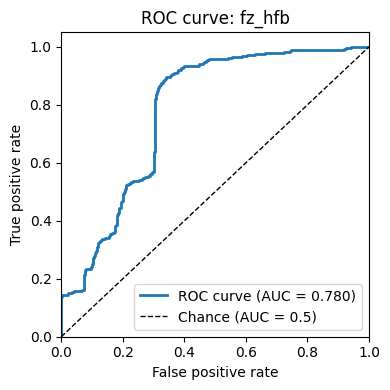

Classification using p3_hfb
Total samples: 2589
  Awake: 764
  Sleep: 1825

Train set: 1812 samples
Test set: 777 samples

Results:
Accuracy:          0.7053
Balanced accuracy: 0.5000
F1-score:          0.0000
ROC-AUC:           0.5000

Confusion matrix:
                Predicted
                Sleep  Awake
Actual  Sleep     548      0
        Awake     229      0


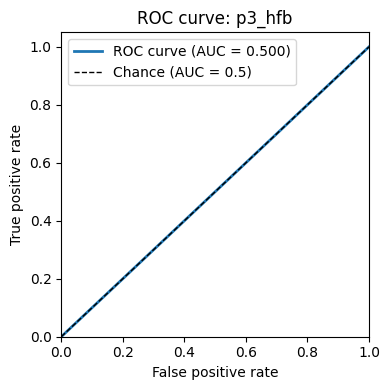

In [9]:
# run logistic regression classifier with random split
fz_results = classify_wake_sleep(df, channel = 'fz_hfb')
p3_results = classify_wake_sleep(df, channel = 'p3_hfb')

Classifier comparison: fz_hfb
Total samples: 3213
  Awake: 1135
  Sleep: 2078

Train set: 2249 samples
Test set: 964 samples

Results summary:
         Classifier  Accuracy  Balanced accuracy  F1-score  ROC-AUC
Logistic regression  0.684647           0.650490  0.544910 0.779988
          SVM (RBF)  0.755187           0.783382  0.717703 0.797077
      Random forest  0.771784           0.753746  0.682081 0.847100
  Gradient boosting  0.814315           0.799925  0.740955 0.889392


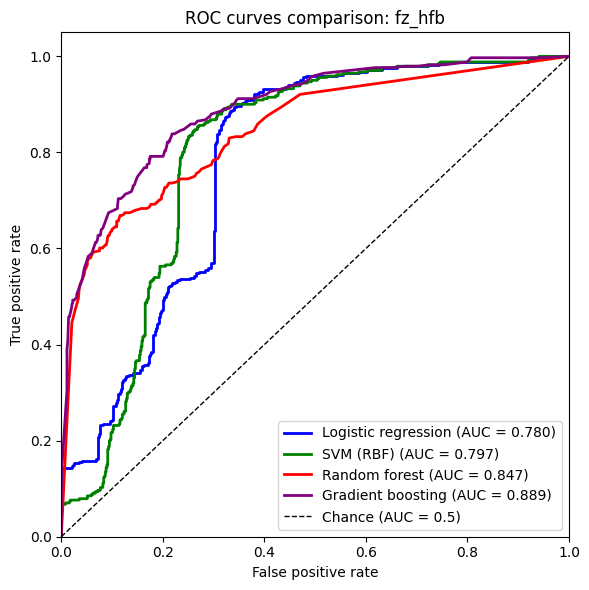

Classifier comparison: p3_hfb
Total samples: 2589
  Awake: 764
  Sleep: 1825

Train set: 1812 samples
Test set: 777 samples

Results summary:
         Classifier  Accuracy  Balanced accuracy  F1-score  ROC-AUC
Logistic regression  0.705277           0.500000  0.000000 0.500000
          SVM (RBF)  0.687259           0.691857  0.569912 0.801135
      Random forest  0.837838           0.801151  0.721239 0.888292
  Gradient boosting  0.877735           0.833248  0.777518 0.934761


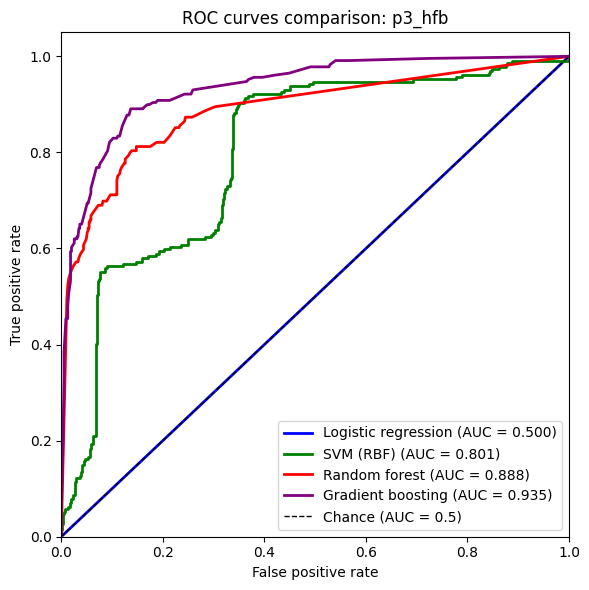

In [10]:
# compare classifiers
fz_comparison = compare_classifiers(df, channel = 'fz_hfb')
p3_comparison = compare_classifiers(df, channel = 'p3_hfb')

### Goal 2.2: Classify wake vs. sleep states with within-subject standardization (subject-based split)

**Classification approach**: To test whether within-subject standardization enables cross-subject generalization, the analysis was repeated with z-scored features and subject-based train/test splitting. Twenty awake and 20 sleep epochs were randomly sampled per subject to balance classes. Features were z-scored per subject to remove individual differences while preserving relative state differences. A subject-based 70/30 split ensured that training and test subjects were completely separate, directly testing generalization to new individuals.

**Results**:
- **Fz HFB**: ROC-AUC = 0.895, accuracy = 0.825, demonstrating strong discrimination between wake and sleep states
- **P3 HFB**: ROC-AUC = 0.519, accuracy = 0.555, demonstrating chance-level performance as expected

**Interpretation**: Within-subject standardization successfully enabled cross-subject generalization for Fz, demonstrating that wake/sleep HFB differences follow consistent within-subject patterns despite substantial between-subject variability in absolute power levels. For clinical deployment, brief calibration sessions to establish subject-specific baseline parameters would enable immediate classification of subsequent recordings. P3 remained at chance level, confirming that standardization does not create artificial signal where none exists.


Classification using fz_hfb with within-subject standardization

Total subjects: 17
Total standardized samples: 680

Train subjects (11): ['Subj12', 'Subj13', 'Subj14', 'Subj16', 'Subj18', 'Subj19', 'Subj2', 'Subj22', 'Subj6', 'Subj7', 'Subj8']
Test subjects (6): ['Subj1', 'Subj10', 'Subj11', 'Subj15', 'Subj17', 'Subj20']

Train set: 440 samples
  Awake: 220, Sleep: 220
Test set: 240 samples
  Awake: 120, Sleep: 120

Results:
Accuracy: 0.8250
F1-score: 0.8190
ROC-AUC:  0.8953

Confusion matrix:
                Predicted
                Sleep  Awake
Actual  Sleep     103     17
        Awake      25     95


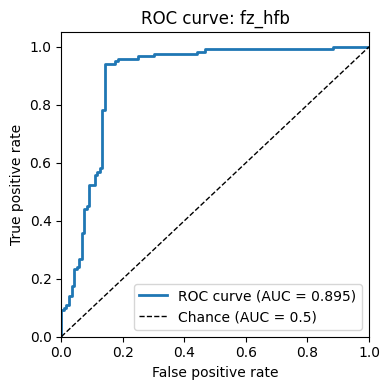


Classification using p3_hfb with within-subject standardization

Total subjects: 14
Total standardized samples: 560

Train subjects (9): ['Subj12', 'Subj13', 'Subj15', 'Subj17', 'Subj19', 'Subj2', 'Subj20', 'Subj6', 'Subj7']
Test subjects (5): ['Subj1', 'Subj10', 'Subj11', 'Subj16', 'Subj18']

Train set: 360 samples
  Awake: 180, Sleep: 180
Test set: 200 samples
  Awake: 100, Sleep: 100

Results:
Accuracy: 0.5550
F1-score: 0.5340
ROC-AUC:  0.5187

Confusion matrix:
                Predicted
                Sleep  Awake
Actual  Sleep      60     40
        Awake      49     51


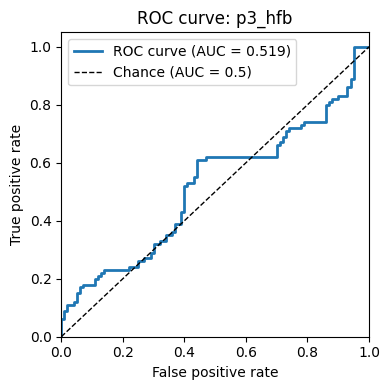

In [11]:
# run logistic regression classifier with subject-based split
f3_results_z = classify_wake_sleep_standardized(df, channel = 'fz_hfb')
p3_results_z = classify_wake_sleep_standardized(df, channel = 'p3_hfb')

### Goal 3.1: Classify wake vs. sleep states using limited data (random split)

**Classification approach**: To test HFB discriminability with minimal data, logistic regression with 10-fold cross-validation classified wake vs. sleep states using only 5 samples per condition from 10 subjects (100 total samples). This approach simulates a realistic scenario where extensive data collection is impractical. Stratified 10-fold CV ensured balanced class representation across folds, with each fold training on 90 samples and testing on 10 samples. The same subjects were used for both Fz and P3 analyses to enable direct comparison.  

**Why 10-fold CV**: With only 100 samples, 10-fold CV provides a balance between training set size (90 samples per fold) and evaluation stability (10 folds for averaging). This approach tests the hypothesis from Holubecki et al., 2025, that HFB wake/sleep differences can be detected with high reliability using as few as 5 samples per state from as few as 10 subjects. The 10-fold CV framework assesses classification performance under these minimal data conditions while providing robust performance estimates by averaging across folds.  

**Results**:
- **Fz HFB**: mean ROC-AUC = 0.792, mean accuracy = 0.66, demonstrating moderate discrimination with limited training data
- **P3 HFB**: mean ROC-AUC = 0.378, mean accuracy = 0.35, demonstrating below-chance-level performance

**Interpretation**: Classification with limited training data remains feasible for Fz but not P3, consistent with the presence of a true discriminative signal in Fz. This suggests that brief data collection sessions (~5 epochs per state, i.e., 25 sec per state) from a modest sample (10 subjects) can support wake/sleep classification using Fz HFB.


Classification using fz_hfb

Selected 10 subjects: ['Subj10', 'Subj11', 'Subj12', 'Subj13', 'Subj15', 'Subj17', 'Subj2', 'Subj20', 'Subj22', 'Subj6']
Samples: 5 per condition per subject

Total samples: 100
  Awake: 50, Sleep: 50

Running 10-fold CV...
Fold 1: Train = 90, Test = 10, Accuracy = 0.600, F1 = 0.500, ROC-AUC = 0.840
Fold 2: Train = 90, Test = 10, Accuracy = 0.500, F1 = 0.444, ROC-AUC = 0.600
Fold 3: Train = 90, Test = 10, Accuracy = 0.700, F1 = 0.667, ROC-AUC = 0.800
Fold 4: Train = 90, Test = 10, Accuracy = 0.800, F1 = 0.800, ROC-AUC = 0.840
Fold 5: Train = 90, Test = 10, Accuracy = 0.800, F1 = 0.800, ROC-AUC = 0.800
Fold 6: Train = 90, Test = 10, Accuracy = 0.600, F1 = 0.333, ROC-AUC = 0.960
Fold 7: Train = 90, Test = 10, Accuracy = 0.800, F1 = 0.833, ROC-AUC = 0.760
Fold 8: Train = 90, Test = 10, Accuracy = 0.500, F1 = 0.286, ROC-AUC = 0.840
Fold 9: Train = 90, Test = 10, Accuracy = 0.800, F1 = 0.750, ROC-AUC = 1.000
Fold 10: Train = 90, Test = 10, Accuracy = 0.500, F1 

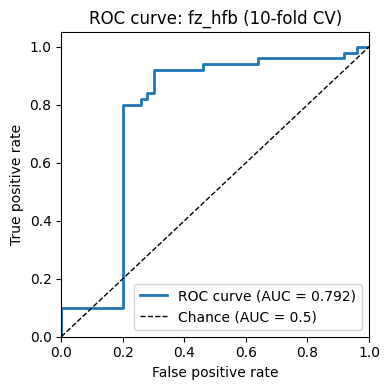


Classification using p3_hfb

Selected 10 subjects: ['Subj10', 'Subj11', 'Subj12', 'Subj13', 'Subj15', 'Subj16', 'Subj17', 'Subj2', 'Subj20', 'Subj7']
Samples: 5 per condition per subject

Total samples: 100
  Awake: 50, Sleep: 50

Running 10-fold CV...
Fold 1: Train = 90, Test = 10, Accuracy = 0.400, F1 = 0.250, ROC-AUC = 0.560
Fold 2: Train = 90, Test = 10, Accuracy = 0.400, F1 = 0.400, ROC-AUC = 0.280
Fold 3: Train = 90, Test = 10, Accuracy = 0.400, F1 = 0.400, ROC-AUC = 0.520
Fold 4: Train = 90, Test = 10, Accuracy = 0.100, F1 = 0.000, ROC-AUC = 0.200
Fold 5: Train = 90, Test = 10, Accuracy = 0.400, F1 = 0.400, ROC-AUC = 0.400
Fold 6: Train = 90, Test = 10, Accuracy = 0.100, F1 = 0.182, ROC-AUC = 0.040
Fold 7: Train = 90, Test = 10, Accuracy = 0.300, F1 = 0.222, ROC-AUC = 0.400
Fold 8: Train = 90, Test = 10, Accuracy = 0.400, F1 = 0.000, ROC-AUC = 0.560
Fold 9: Train = 90, Test = 10, Accuracy = 0.500, F1 = 0.000, ROC-AUC = 0.500
Fold 10: Train = 90, Test = 10, Accuracy = 0.500, F1 

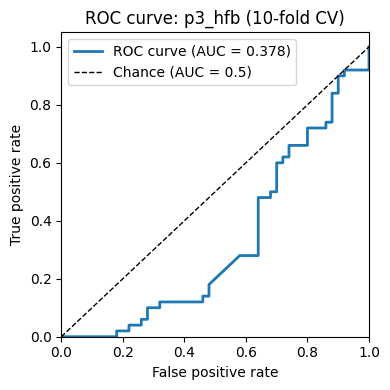

In [12]:
# run 10-fold CV with random split
fz_results_10fold = classify_kfold(df, channel = 'fz_hfb', n_subj = 10, n_per_cond = 5, n_folds = 10)
p3_results_10fold = classify_kfold(df, channel = 'p3_hfb', n_subj = 10, n_per_cond = 5, n_folds = 10)

### Goal 3.2: Classify wake vs. sleep states using limited data with within-subject standardization (leave one subject out)

**Classification approach**: To test whether within-subject standardization enables cross-subject generalization with limited data, the analysis was repeated with z-scored features using leave-one-subject-out cross-validation (LOOCV). Features were z-scored per subject (using balanced classes with 40 total epochs as in Goal 2.2) to remove individual differences while preserving relative state differences. Five awake and 5 sleep epochs were randomly sampled per subject to match the minimal data conditions of Goal 3.1. LOOCV ensured that the test subject was completely separate from training subjects, directly testing generalization to new individuals with minimal training data.

**Results**:
- **Fz HFB**: mean ROC-AUC = 0.82, mean accuracy = 0.81, demonstrating good discrimination with limited data and cross-subject generalization
- **P3 HFB**: mean ROC-AUC = 0.696, mean accuracy = 0.69, demonstrating above-chance performance

**Interpretation**: Within-subject standardization enabled cross-subject generalization with limited data for Fz. However, P3 showed unexpected above-chance performance, likely reflecting overfitting to noise in limited data. This suggests that brief data collection sessions from a modest sample can support wake/sleep classification within subjects using Fz HFB, but not cross-subject generalization.


Classification using fz_hfb
Selected 10 subjects: ['Subj10', 'Subj11', 'Subj12', 'Subj13', 'Subj15', 'Subj17', 'Subj2', 'Subj20', 'Subj22', 'Subj6']
Samples: 5 per condition per subject

Total samples: 100
  Awake: 50, Sleep: 50

Running leave-one-subject-out CV...
Fold 1 (test: Subj10): Train = 90, Test = 10, Accuracy = 1.000, F1 = 1.000, ROC-AUC = 1.000
Fold 2 (test: Subj11): Train = 90, Test = 10, Accuracy = 1.000, F1 = 1.000, ROC-AUC = 1.000
Fold 3 (test: Subj12): Train = 90, Test = 10, Accuracy = 1.000, F1 = 1.000, ROC-AUC = 1.000
Fold 4 (test: Subj13): Train = 90, Test = 10, Accuracy = 0.000, F1 = 0.000, ROC-AUC = 0.000
Fold 5 (test: Subj15): Train = 90, Test = 10, Accuracy = 1.000, F1 = 1.000, ROC-AUC = 1.000
Fold 6 (test: Subj17): Train = 90, Test = 10, Accuracy = 1.000, F1 = 1.000, ROC-AUC = 1.000
Fold 7 (test: Subj2): Train = 90, Test = 10, Accuracy = 0.200, F1 = 0.333, ROC-AUC = 0.200
Fold 8 (test: Subj20): Train = 90, Test = 10, Accuracy = 0.900, F1 = 0.889, ROC-AUC = 1.00

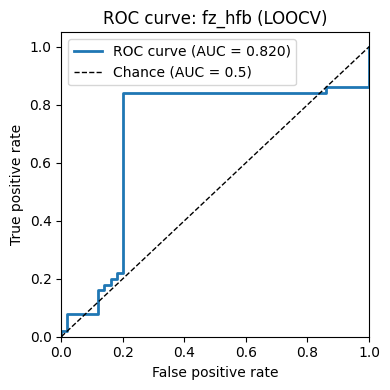


Classification using p3_hfb
Selected 10 subjects: ['Subj10', 'Subj11', 'Subj12', 'Subj13', 'Subj15', 'Subj16', 'Subj17', 'Subj2', 'Subj20', 'Subj7']
Samples: 5 per condition per subject

Total samples: 100
  Awake: 50, Sleep: 50

Running leave-one-subject-out CV...
Fold 1 (test: Subj10): Train = 90, Test = 10, Accuracy = 1.000, F1 = 1.000, ROC-AUC = 1.000
Fold 2 (test: Subj11): Train = 90, Test = 10, Accuracy = 0.000, F1 = 0.000, ROC-AUC = 0.000
Fold 3 (test: Subj12): Train = 90, Test = 10, Accuracy = 1.000, F1 = 1.000, ROC-AUC = 1.000
Fold 4 (test: Subj13): Train = 90, Test = 10, Accuracy = 0.000, F1 = 0.000, ROC-AUC = 0.000
Fold 5 (test: Subj15): Train = 90, Test = 10, Accuracy = 1.000, F1 = 1.000, ROC-AUC = 1.000
Fold 6 (test: Subj16): Train = 90, Test = 10, Accuracy = 0.900, F1 = 0.889, ROC-AUC = 0.960
Fold 7 (test: Subj17): Train = 90, Test = 10, Accuracy = 1.000, F1 = 1.000, ROC-AUC = 1.000
Fold 8 (test: Subj2): Train = 90, Test = 10, Accuracy = 1.000, F1 = 1.000, ROC-AUC = 1.00

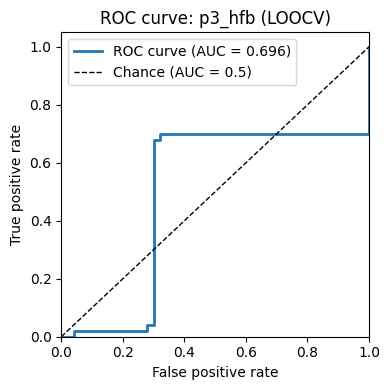

In [13]:
# run LOOCV
fz_results_loocv = classify_loocv_standardized(df, channel = 'fz_hfb', n_subj = 10, n_per_cond = 5)
p3_results_loocv = classify_loocv_standardized(df, channel = 'p3_hfb', n_subj = 10, n_per_cond = 5)